In [68]:
import copy
from typing import Callable
from dataclasses import dataclass

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.dpi"] = 100

from PointSystem import PointSystem
from scipy.spatial import Delaunay

In [3]:
def ExplicitRungeKuttaFourthOrder(f: callable, X: np.array, dt: float):
    
    k1 = f(X.copy())
    k2 = f(X.copy() + k1 * dt / 2)
    k3 = f(X.copy() + k2 * dt / 2)
    k4 = f(X.copy() + k3 * dt)
    X += dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    # X += 

    N = X.shape[0] // 4
    
    X[0] = 0
    X[1] = 1
    X[2] = 0
    X[3] = 1
    
    X[0 + 2*N] = 0
    X[1 + 2*N] = 0
    X[2 + 2*N] = 1
    X[3 + 2*N] = 1

    for i in range(0, N):
        if X[i] > 1:
            X[i] = 1
        if X[i] < 0:
            X[i] = 0

    for i in range(2*N, 3*N):
        if X[i] > 1:
            X[i] = 1
        if X[i] < 0:
            X[i] = 0

    return X

In [4]:
f = lambda point: np.exp((-np.power(np.linalg.norm(point-0.5), 2)) / (0.5/2)**2) * 100
import plotly.graph_objects as go
n, m = 100, 100

# ng = lambda i, j: noise_generator([i/n, j/m]) * 10 + 6
noise = np.array([[f(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])

fig = go.Figure(data=[
    go.Surface(z=noise)
    ])
fig.update_layout(title='surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [5]:
def borderF(f: Callable[[float, float], float], x: float):
    if x < 1:
        return f(x, 0)
    elif 1 <= x < 2:
        return f(1, x - 1)
    elif 2 <= x < 3:
        return f(x - 2, 1)
    elif 3 <= x <= 4:
        return f(0, x - 3)
    else:
        return borderF(f, x - 4)
        # raise ValueError('Out of range')

def NewtonRootFinder(f: Callable[[float], float], x0: float, Df: Callable[[float], float] = None, eps=10e-4, maxIterations=1000):
    if Df is None: Df = lambda x: (f(x + eps/2) - f(x - eps/2)) / eps
    x = x0
    for n in range(0, maxIterations):
        fx = f(x)
        if abs(fx) < eps:
            return x
        Dfx = Df(x)
        if Dfx == 0:
            return None
        x -= fx/Dfx
    return None

def makeGrid(f: Callable[[float], float], a, b, h) -> list[float]:

    x = a
    # x_uniform = a
    grid: list[float] = list()
    while x < b:
        grid.append(x)
        x = NewtonRootFinder(lambda xi: xi - x - 1 / f((xi + x) / 2), x)
        # x_uniform += h
    
    grid.append(b)
    
    return grid


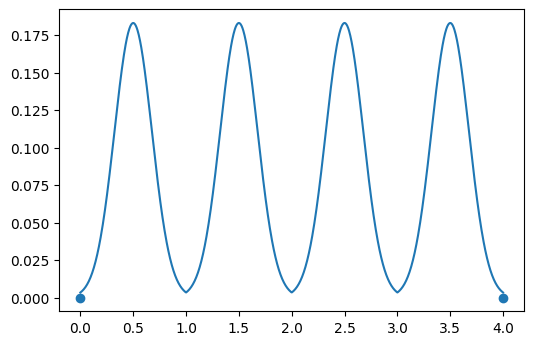

In [6]:
f = lambda x, y: np.exp((-np.power(np.linalg.norm(np.array([x, y])-0.5), 2)) / (0.5/2)**2) * 10
grid = makeGrid(lambda x: borderF(f, x), 0, 4, 0.001)
X = np.linspace(0, 4, 1000)
plt.scatter(grid, np.zeros(len(grid)))
plt.plot(X, np.vectorize(lambda x: borderF(f, x))(X))
plt.show()

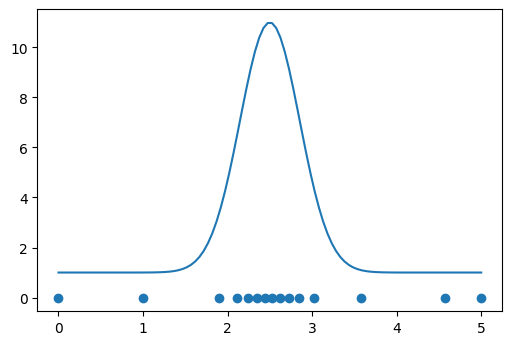

In [7]:
grid = makeGrid(lambda x: np.exp((-np.power(np.linalg.norm(np.array([x])-2.5), 2)) / (0.5/1)**2) * 10 + 1, 0, 5, 0.1)
X = np.linspace(0, 5, 100)
plt.scatter(grid, np.zeros(len(grid)))
plt.plot(X, np.vectorize(lambda x: np.exp((-np.power(np.linalg.norm(np.array([x])-2.5), 2)) / (0.5/1)**2) * 10 + 1)(X))
plt.show()

In [67]:
a = np.array([np.random.rand(3), np.random.rand(3)])
a, a.transpose()

(array([[0.64913682, 0.19380506, 0.98446592],
        [0.47534423, 0.71282988, 0.14277836]]),
 array([[0.64913682, 0.47534423],
        [0.19380506, 0.71282988],
        [0.98446592, 0.14277836]]))

In [58]:
def F(X: np.array) -> np.array:

    f = lambda point: np.exp((-np.power(np.linalg.norm(point-0.5), 2)) / (0.5/2)**2) * 100 + 1

    N: int = X.shape[0] // 4

    xs = X[:N]
    vxs = X[N:2*N]
    ys = X[2*N:3*N]
    vys = X[3*N:4*N]

    new_vxs = np.zeros((N))
    new_vys = np.zeros((N))

    points = np.array([xs, ys]).transpose()
    tri = Delaunay(points)
    _, edges_dict = PointSystem.calculateEdges(tri)
    
    for i in range(0, N):
        for j in range(0, N):
            if i != j:
                xa, ya = xs[j], ys[j]
                xb, yb = xs[i], ys[i]
                middleX = (xa + xb) / 2
                middleY = (ya + yb) / 2
                distance = np.sqrt(np.power(xa - xb, 2) + np.power(ya - yb, 2))
                d0 = 1 / f(np.array([middleX, middleY]))
                K = 10
                if distance > d0:
                    # if distance > np.pi * d0:
                    #     continue
                    new_vxs[i] += K * (xa - xb)/1#f(np.array([middleX, middleY])) / 100
                    new_vys[i] += K * (ya - yb)/1#f(np.array([middleX, middleY])) / 100
                else:
                    new_vxs[i] += -K * (xa - xb)/1#/f(np.array([middleX, middleY])) / 100
                    new_vys[i] += -K * (ya - yb)/1#/f(np.array([middleX, middleY])) / 100
    
    for i in range(0, N):
        xs[i] = vxs[i]
    
    for i in range(0, N):
        ys[i] = vys[i]

    return np.concatenate(
        (
            xs,
            new_vxs,
            ys,
            new_vys
        )
    )

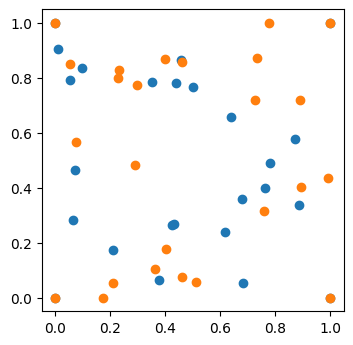

In [59]:
N = 25
# X = np.concatenate(
#     (
#         np.random.rand(N),# np.array([1/4 * np.cos(phi) + 1/2 for phi in np.linspace(0, 2*np.pi, N)]),
#         np.random.rand(N)/100,
#         np.random.rand(N),# np.array([1/4 * np.sin(phi) + 1/2 for phi in np.linspace(0, 2*np.pi, N)]),
#         np.random.rand(N)/100
#     )
# )
X = np.concatenate(
    (
        np.array([0, 1, 0, 1]),
        np.random.rand(N - 4),# np.array([1/4 * np.cos(phi) + 1/2 for phi in np.linspace(0, 2*np.pi, N)]),
        np.zeros(4),
        np.random.rand(N - 4)/100,
        np.array([0, 0, 1, 1]),
        np.random.rand(N - 4),# np.array([1/4 * np.sin(phi) + 1/2 for phi in np.linspace(0, 2*np.pi, N)]),
        np.zeros(4),
        np.random.rand(N - 4)/100
    )
)
plt.scatter(X[0:N], X[2*N:3*N])
# plt.gca().set_aspect('equal', adjustable='box')

T = 100
dt = 0.1

Fs = list()
Fs.append(X.copy())
t = 0

while t < T:
    X = ExplicitRungeKuttaFourthOrder(F, X.copy(), dt)
    Fs.append(X.copy())
    t += dt

X = Fs[-1]
plt.scatter(X[0:N], X[2*N:3*N])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Fs

MovieWriter ffmpeg unavailable; using Pillow instead.


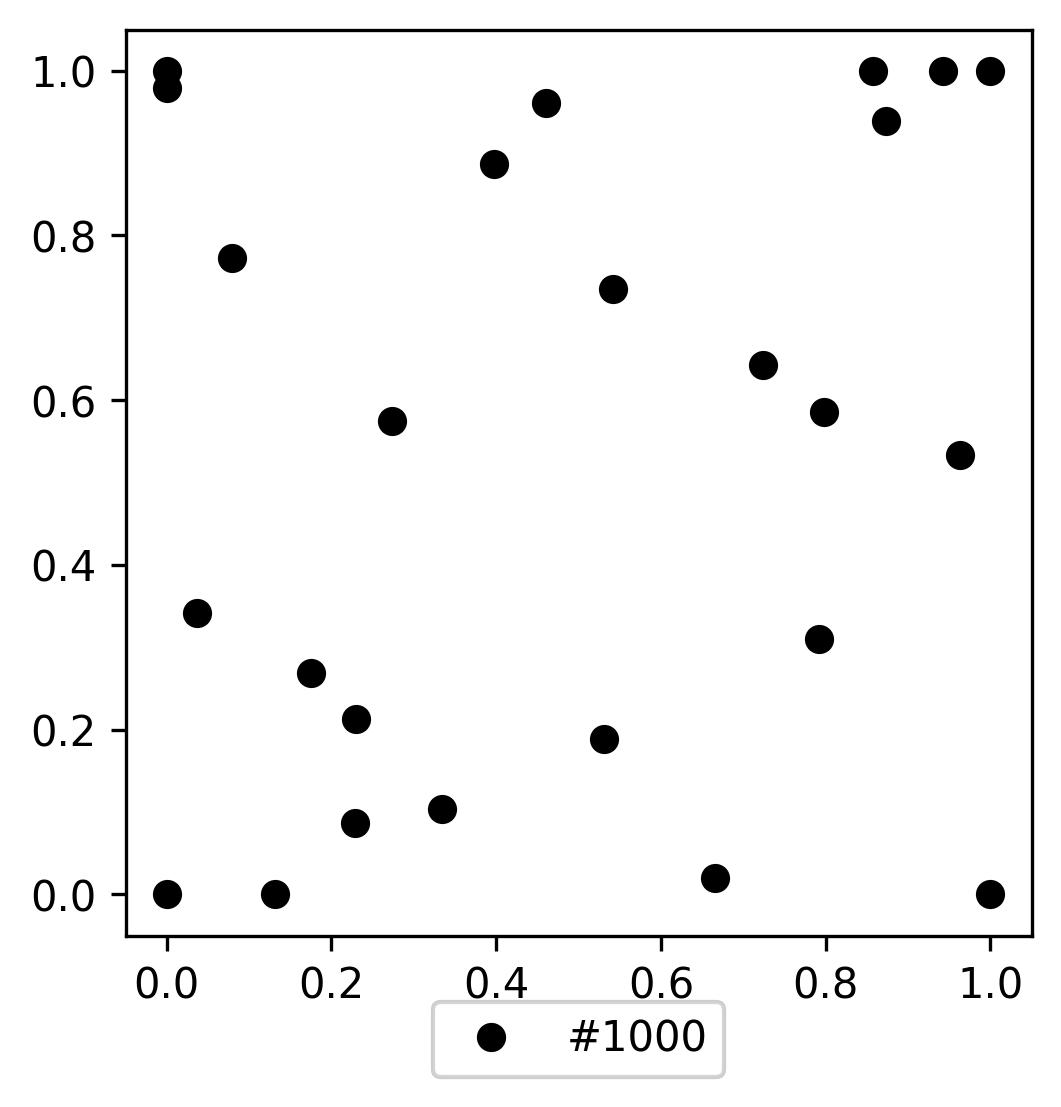

In [60]:
from celluloid import Camera

n, m = 100, 100
# ng = lambda i, j: noise_generator([i/n, j/m]) * 10 + 6
# noise = np.array([[ng(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])
extent = [0, 1, 0, 1]
fig = plt.figure(dpi = 300)
# im = plt.imshow(noise, extent=extent, cmap='RdBu', interpolation='nearest')

plt.gca().set_aspect('equal', adjustable='box')

camera = Camera(fig)
for i, X in enumerate(Fs[:]):
    if i % 10 == 0:
        # tri = ps[0].triangulation
        # points = ps[0].points
        # plt.triplot(points[:,0], points[:,1], tri.simplices, color='grey')
        # print(X)
        t = plt.plot(X[0:N], X[2*N:3*N], 'o', color='black')
        # im = plt.imshow(noise, extent=extent, cmap='RdBu', interpolation='nearest')
        # plt.colorbar(im)
        plt.legend(t, [f'#{i}'], loc='upper center', bbox_to_anchor=(0.5, -0.05))
        camera.snap()

animation = camera.animate()
animation.save('evolution_animation.gif')

In [11]:
@dataclass
class vectorFunction:
    variables: list[str]
    functions: list[callable]

    def __init__(self, variables, functions):
        if len(variables) != len(functions):
            raise ValueError("variables and functions list size don't match")
        
        self.variables = variables
        self.functions = functions
    
    def __call__(self, X):
        return np.array([f(X) for f in self.functions])

In [3]:
s = 10
r = 28
b = 8/3
f = lambda x, y, z: s*(y-x)
fs = vectorFunction(['x', 'y', 'z'], [lambda point: s*(point[1]-point[0]), lambda point: point[0]*(r-point[2])-point[1], lambda point: point[0]*point[1]-b*point[2]])
fs(np.array([0.1, 0.1, 0.1]))

array([ 0.        ,  2.69      , -0.25666667])

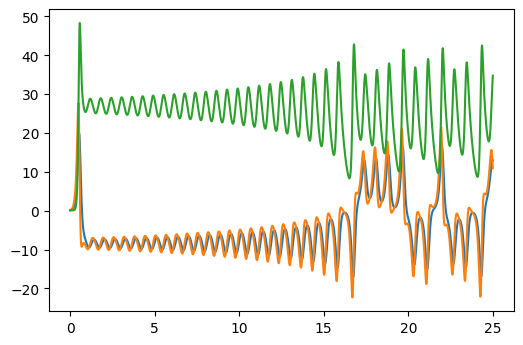

In [10]:
f = lambda point: np.sin(point)

X = np.array([0.1, 0.1, 0.1])

T = 25
dt = 0.01

F = list()
F.append(X)
t = 0
while t < T:
    F.append(ExplicitRungeKuttaFourthOrder(fs, F[-1].copy(), dt))
    t += dt

plt.plot(np.linspace(0, T, int(T/dt) + 1), F)
plt.show()